# DATA VISUALIZATION
## Load Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
import datetime
import pickle

pd.set_option('display.max_columns', None) # no truncate columns

In [112]:
#Environment settings
data_path_in = 'Data/input/'
data_path_out = 'Data/output/'

data_type = {
    'StoreID': 'uint16',
    'Date': str,
    'IsHoliday': bool,
    'IsOpen': bool,
    'HasPromotions': bool,
    'StoreType': 'category',
    'AssortmentType': 'category',
    'NearestCompetitor': 'uint32',
    'Region': int,
    'NumberOfCustomers': 'uint16',
    'NumberOfSales': 'uint16',
    'Region_AreaKM2': 'uint16',
    'Region_GDP': 'uint16',
    'Region_PopulationK': 'uint16',
    'CloudCover': 'float32',
    'Events': 'category',
    'Max_Dew_PointC': 'int8',
    'Max_Gust_SpeedKm_h': 'float32', # 'uint8'
    'Max_Humidity': 'uint8',
    'Max_Sea_Level_PressurehPa': 'uint16',
    'Max_TemperatureC': 'int8',
    'Max_VisibilityKm': 'float32', # 'uint8'
    'Max_Wind_SpeedKm_h': 'uint8',
    'Mean_Dew_PointC': 'int8',
    'Mean_Humidity': 'uint8',
    'Mean_Sea_Level_PressurehPa': 'uint16',
    'Mean_TemperatureC': 'int8',
    'Mean_VisibilityKm': 'float32', # 'uint8'
    'Mean_Wind_SpeedKm_h': 'uint8',
    'Min_Dew_PointC': 'int8',
    'Min_Humidity': 'uint8',
    'Min_Sea_Level_PressurehPa': 'uint16',
    'Min_TemperatureC': 'int8',
    'Min_VisibilitykM': 'float32', #'uint8'
    'Precipitationmm': 'float32',
    'WindDirDegrees': 'int16'
}

# load and serialize dataframes for later use in preprocessing notebook
df = {}
for ds_name in ['train', 'test']:
    df[ds_name] = pd.read_csv(data_path_in+ds_name+'.csv', dtype=data_type, parse_dates=["Date"], dayfirst=True)
    with open(data_path_out+ds_name+'_dv.obj', 'wb') as file:
        pickle.dump(df, file)

train = df['train']
test = df['test']

In [113]:
print("Train set has shape {}.\nTest set has shape {}" .format(train.shape, test.shape))

Train set has shape (523021, 36).
Test set has shape (45689, 34)


## Combining train & test data

In [114]:
X = train.copy()
X = X.drop(columns=['NumberOfCustomers', 'NumberOfSales'], axis=1)
y = train.loc[:, 'NumberOfCustomers':'NumberOfSales']

all_data = pd.concat([X, test], axis=0).reset_index()

#to restore the original column order
all_data = all_data[list(test.columns.values)]
all_data.head(10)


StoreID       Date  IsHoliday  IsOpen  HasPromotions     StoreType  \
0     1000 2016-03-01      False    True          False  Hyper Market   
1     1000 2016-03-02      False    True          False  Hyper Market   
2     1000 2016-03-04      False    True          False  Hyper Market   
3     1000 2016-03-05      False    True          False  Hyper Market   
4     1000 2016-03-06      False   False          False  Hyper Market   
5     1000 2016-03-07      False    True           True  Hyper Market   
6     1000 2016-03-08      False    True           True  Hyper Market   
7     1000 2016-03-09      False    True           True  Hyper Market   
8     1000 2016-03-10      False    True           True  Hyper Market   
9     1000 2016-03-11      False    True           True  Hyper Market   

  AssortmentType  NearestCompetitor  Region  Region_AreaKM2  Region_GDP  \
0        General                326       7            9643       17130   
1        General                326       7            9643       17130   
2        General                326       7            9643       17130   
3        General                326       7            9643       17130   
4        General                326       7            9643       17130   
5        General                326       7            9643       17130   
6        General                326       7            9643       17130   
7        General                326       7            9643       17130   
8        General                326       7            9643       17130   
9        General                326       7            9643       17130   

   Region_PopulationK  CloudCover     Events  Max_Dew_PointC  \
0                2770         8.0  Rain-Snow               1   
1                2770         8.0       Snow               0   
2                2770         8.0       Rain               0   
3                2770         6.0        NaN              -3   
4                2770         6.0        NaN               0   
5                2770         NaN        NaN              -2   
6                2770         NaN        NaN              -1   
7                2770         NaN        NaN               2   
8                2770         7.0       Rain               8   
9                2770         7.0       Rain               8   

   Max_Gust_SpeedKm_h  Max_Humidity  Max_Sea_Level_PressurehPa  \
0                 NaN           100                       1032   
1                 NaN            87                       1030   
2                 NaN            81                       1026   
3                 NaN            80                       1027   
4                 NaN            93                       1025   
5                 NaN            93                       1024   
6                 NaN            87                       1017   
7                 NaN            93                       1009   
8                 NaN            87                       1002   
9                 NaN            93                       1002   

   Max_TemperatureC  Max_VisibilityKm  Max_Wind_SpeedKm_h  Mean_Dew_PointC  \
0                 2              19.0                  21               -1   
1                 5              23.0                  16               -1   
2                 4              31.0                  23               -1   
3                 8              31.0                  19               -4   
4                 7              31.0                  16               -3   
5                11              31.0                  24               -3   
6                13              26.0                  14               -2   
7                15              26.0                  16               -1   
8                16              26.0                  13                2   
9                17              14.0                  14                7   

   Mean_Humidity  Mean_Sea_Level_PressurehPa  Mean_TemperatureC  \
0             8

## 1. Numerical features

In [115]:
numeric_features = all_data.select_dtypes(include=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 27 numeric features (79.41% of total) 


In [116]:
numeric_features

StoreID  NearestCompetitor  Region  Region_AreaKM2  Region_GDP  \
0          1000                326       7            9643       17130   
1          1000                326       7            9643       17130   
2          1000                326       7            9643       17130   
3          1000                326       7            9643       17130   
4          1000                326       7            9643       17130   
5          1000                326       7            9643       17130   
6          1000                326       7            9643       17130   
7          1000                326       7            9643       17130   
8          1000                326       7            9643       17130   
9          1000                326       7            9643       17130   
10         1000                326       7            9643       17130   
11         1000                326       7            9643       17130   
12         1000                326       7            9643       17130   
13         1000                326       7            9643       17130   
14         1000                326       7            9643       17130   
15         1000                326       7            9643       17130   
16         1000                326       7            9643       17130   
17         1000                326       7            9643       17130   
18         1000                326       7            9643       17130   
19         1000                326       7            9643       17130   
20         1000                326       7            9643       17130   
21         1000                326       7            9643       17130   
22         1000                326       7            9643       17130   
23         1000                326       7            9643       17130   
24         1000                326       7            9643       17130   
25         1000                326       7            9643       17130   
26         1000                326       7            9643       17130   
27         1000                326       7            9643       17130   
28         1000                326       7            9643       17130   
29         1000                326       7            9643       17130   
...         ...                ...     ...             ...         ...   
568680     1748               4607       7            9643       17130   
568681     1748               4607       7            9643       17130   
568682     1748               4607       7            9643       17130   
568683     1748               4607       7            9643       17130   
568684     1748               4607       7            9643       17130   
568685     1748               4607       7            9643       17130   
568686     1748               4607       7            9643       17130   
568687     1748               4607       7            9643       17130   
568688     1748               4607       7            9643       17130   
568689     1748               4607       7            9643       17130   
568690     1748               4607       7            9643       17130   
568691     1748               4607       7            9643       17130   
568692     1748               4607       7            9643       17130   
568693     1748               4607       7            9643       17130   
568694     1748               4607       7            9643       17130   
568695     1748               4607       7            9643       17130   
568696     1748               4607       7            9643       17130   
568697     1748               4607       7            9643       17130   
568698     1748               4607       7            9643       17130   
568699     1748               4607       7            9643       17130   
568700     1748               4607       7            9643       17130   
568701     1748               4607       7            9643       17130   
568702     1

In [117]:
all_data.describe()

StoreID  NearestCompetitor         Region  Region_AreaKM2  \
count  568710.000000      568710.000000  568710.000000   568710.000000   
mean     1373.957616        7999.119534       5.700586    12448.404758   
std       216.381498       11529.083651       3.358435     9197.663508   
min      1000.000000          47.000000       0.000000      344.000000   
25%      1187.000000        1057.000000       3.000000     7215.000000   
50%      1373.000000        3321.000000       6.000000     9643.000000   
75%      1561.000000        9673.000000       9.000000    15566.000000   
max      1748.000000       85070.000000      10.000000    32221.000000   

          Region_GDP  Region_PopulationK     CloudCover  Max_Dew_PointC  \
count  568710.000000       568710.000000  519111.000000   568710.000000   
mean    14057.774367         3867.832217       5.560682        8.196299   
std      2753.553082         2814.035417       1.719444        5.905485   
min      9893.000000          816.000000       0.000000      -14.000000   
25%     11849.000000         1293.000000       5.000000        4.000000   
50%     15017.000000         2770.000000       6.000000        8.000000   
75%     15931.000000         5727.000000       7.000000       13.000000   
max     23931.000000         8146.000000       8.000000       23.000000   

       Max_Gust_SpeedKm_h   Max_Humidity  Max_Sea_Level_PressurehPa  \
count       124325.000000  568710.000000              568710.000000   
mean            48.544918      93.401607                1018.554787   
std             13.393154       7.622350                   8.128224   
min             21.000000      44.000000                 976.000000   
25%             39.000000      89.000000                1013.000000   
50%             47.000000      94.000000                1019.000000   
75%             55.000000     100.000000                1024.000000   
max            106.000000     100.000000                1043.000000   

       Max_TemperatureC  Max_VisibilityKm  Max_Wind_SpeedKm_h  \
count     568710.000000     554751.000000       568710.000000   
mean          14.250695         23.649191           22.405618   
std            7.997932          9.153078            8.958702   
min          -11.000000          0.000000            3.000000   
25%            8.000000         11.000000           16.000000   
50%           14.000000         31.000000           21.000000   
75%           20.000000         31.000000           27.000000   
max           37.000000         31.000000          101.000000   

       Mean_Dew_PointC  Mean_Humidity  Mean_Sea_Level_PressurehPa  \
count    568710.000000  568710.000000               568710.000000   
mean          5.872554      74.302602                 1015.373630   
std           5.830991      12.977769                    8.443824   
min         -15.000000      30.000000                  974.000000   
25%           2.000000      65.000000                 1010.000000   
50%           6.000000      76.000000                 1016.000000   
75%          11.000000      84.000000                 1021.000000   
max          20.000000     100.000000                 1040.000000   

       Mean_TemperatureC  Mean_VisibilityKm  Mean_Wind_SpeedKm_h  \
count      568710.000000      554751.000000        568710.000000   
mean           10.011000          12.250188            11.784913   
std             6.883573           5.021622             5.878919   
min           -13.000000           0.000000             2.000000   
25%             4.000000          10.000000             8.000000   
50%            10.000000          11.000000            11.000000   
75%            16.000000          14.000000            14.000000   
max            30.000000          31.000000            53.000000   

       Min_Dew_PointC   Min_Humidity  Min_Sea_Level_PressurehPa  \
count   568710.000000  568710.000000              568710.000000   
mean         3.340256      50.406260                1012.401630   
std     

### Date manipulation

In [118]:
all_data.Date.head()

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: Date, dtype: datetime64[ns]

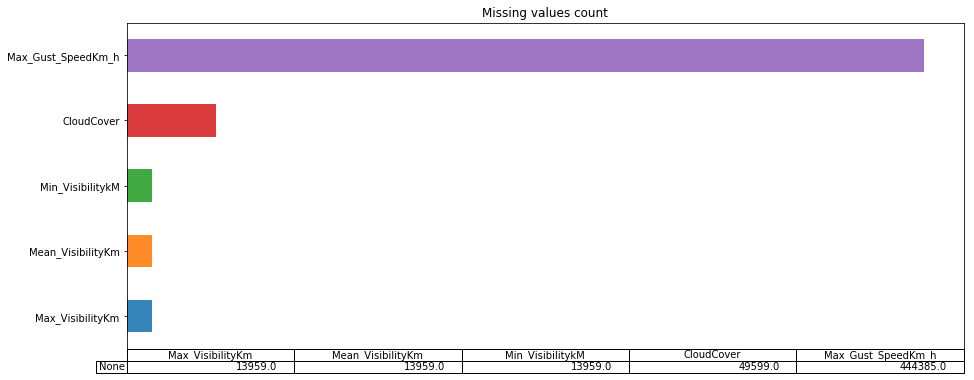

In [119]:
# Missing values
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

### Max_Gust_SpeedKm_h

In [120]:
all_data = all_data.drop('Max_Gust_SpeedKm_h', axis=1)
all_data.shape

(568710, 33)

### CloudCover & Visibility

In [121]:
nan_index = all_data[all_data['CloudCover'].isnull()].index.tolist()
# for i in nan_index:
#     curr_date = all_data.loc[i,'Date']
#     curr_region = all_data.loc[i,'Region']
#     regional_stores = all_data[(all_data.Date == curr_date) & (all_data.Region == curr_region)]
#     curr_mode = regional_stores['CloudCover'].mode()


# 

### Time - sales visualization

In [122]:
stores = {}
for storeid in train.StoreID.unique():
    stores[storeid] = pd.DataFrame(train[train["StoreID"] == storeid])
    stores[storeid] = stores[storeid].set_index("Date")

In [123]:
#ax = stores[1000].plot(y="NumberOfSales",figsize=(20,10))
#for key,store in stores.items():
#    store.plot(ax=ax, y="NumberOfSales")

0


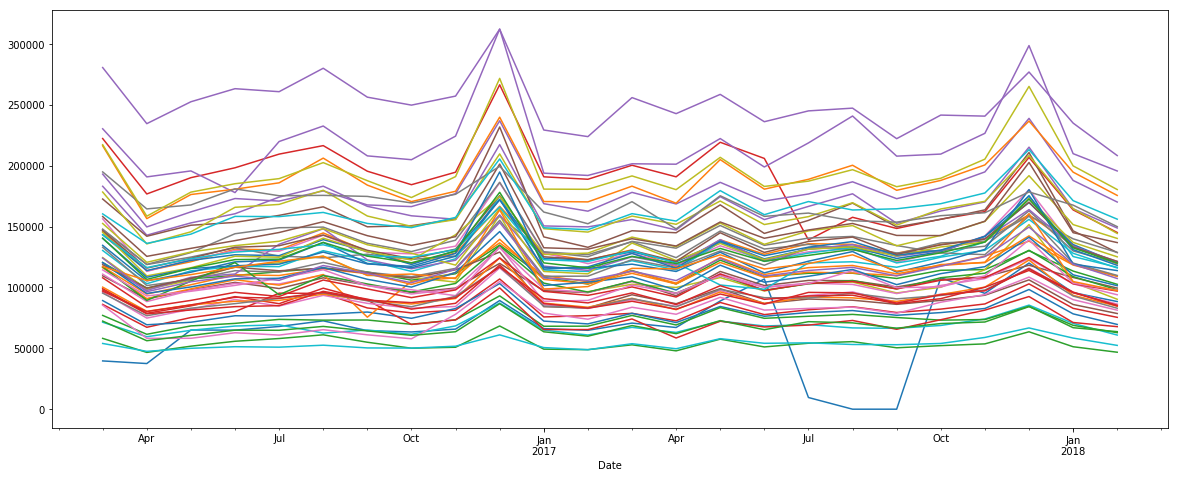

1


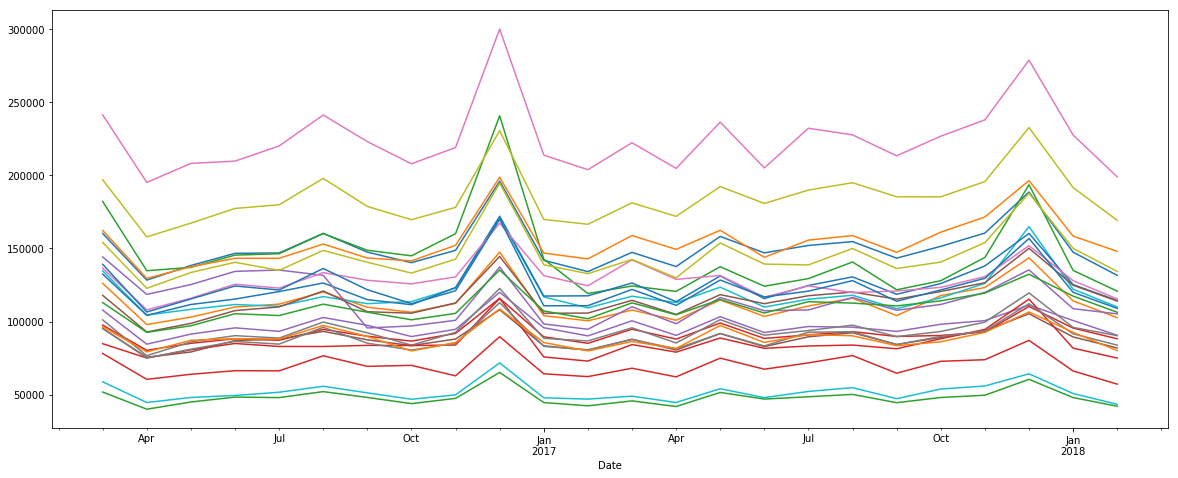

2


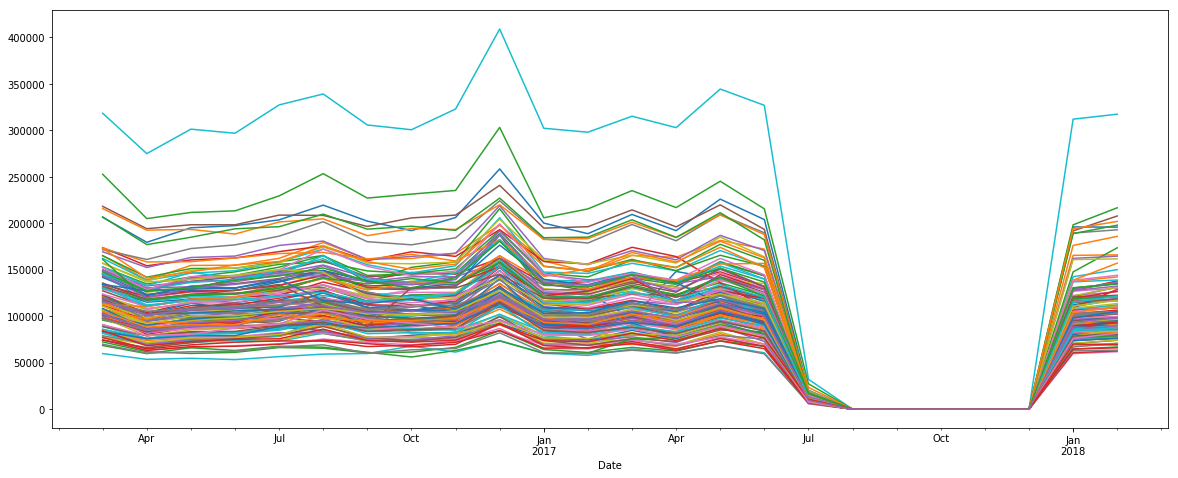

3


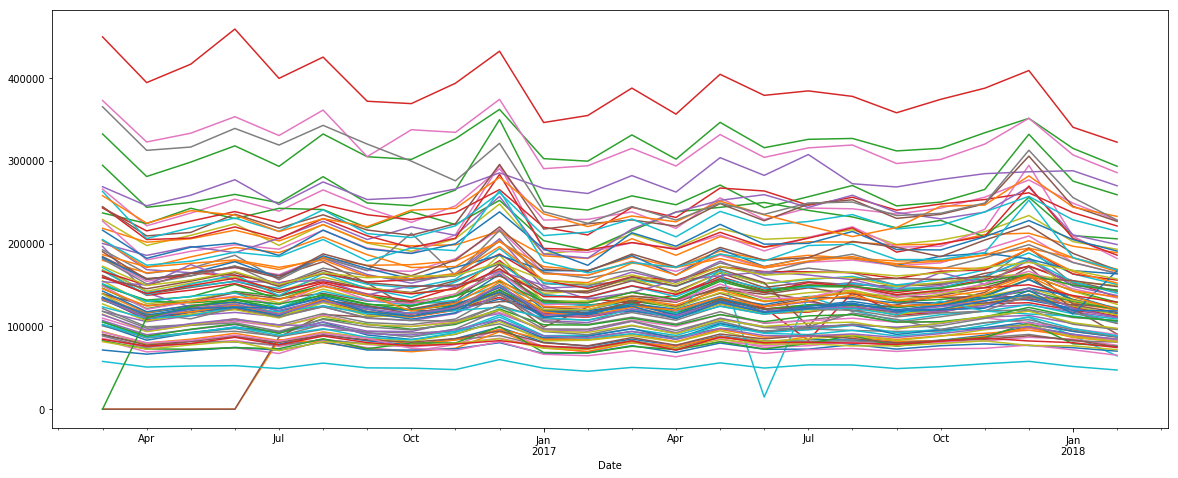

4


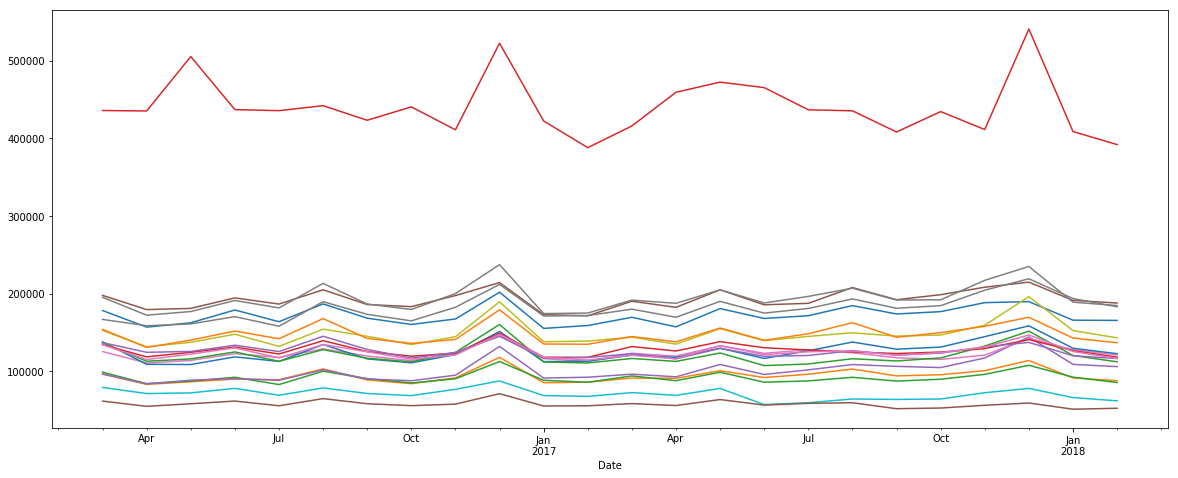

5


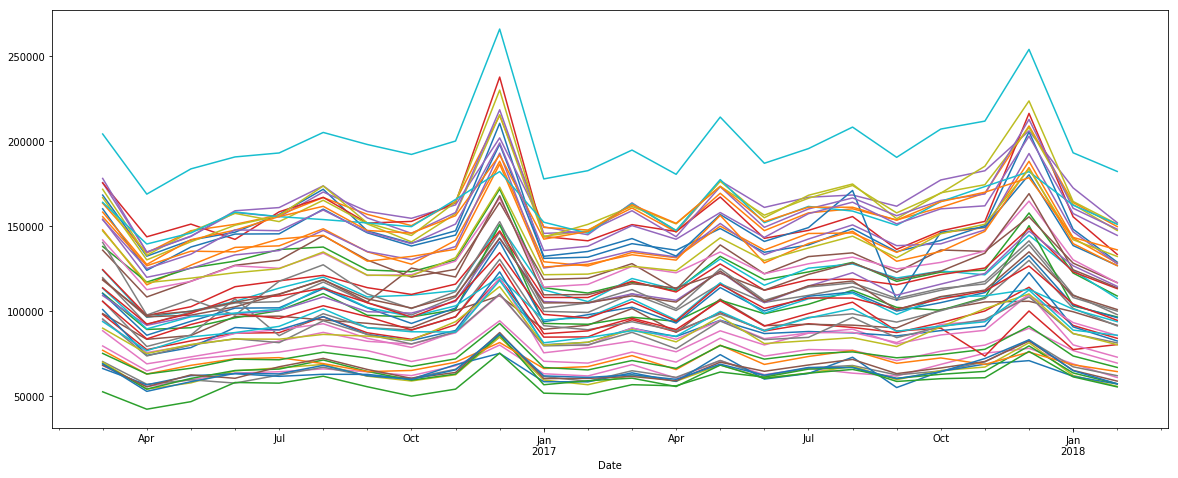

6


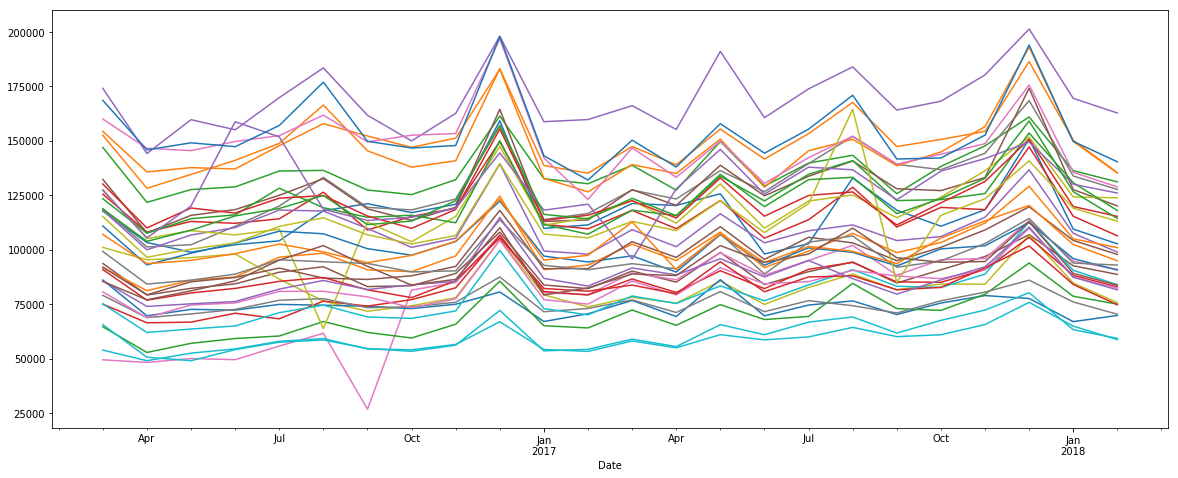

7


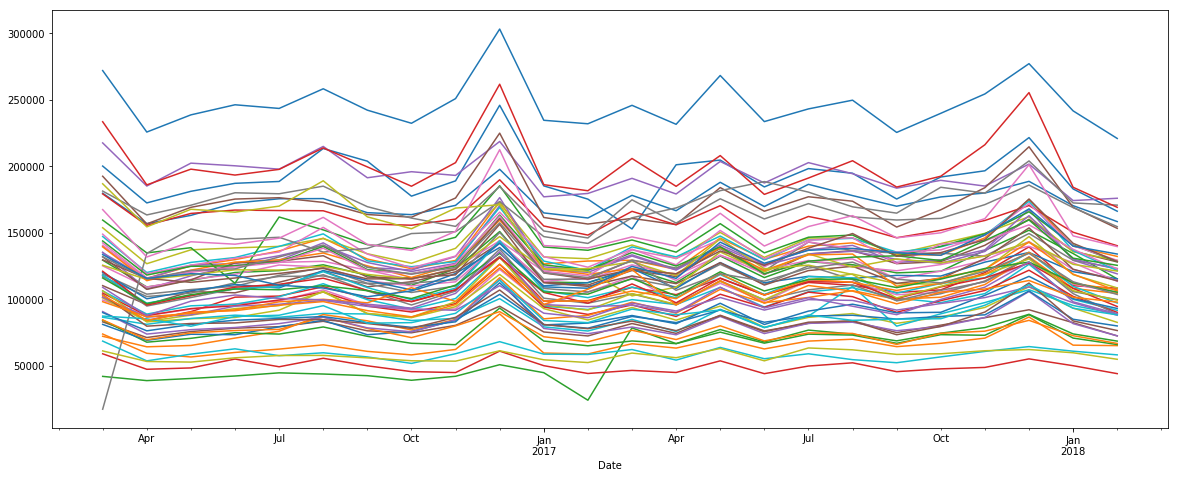

8


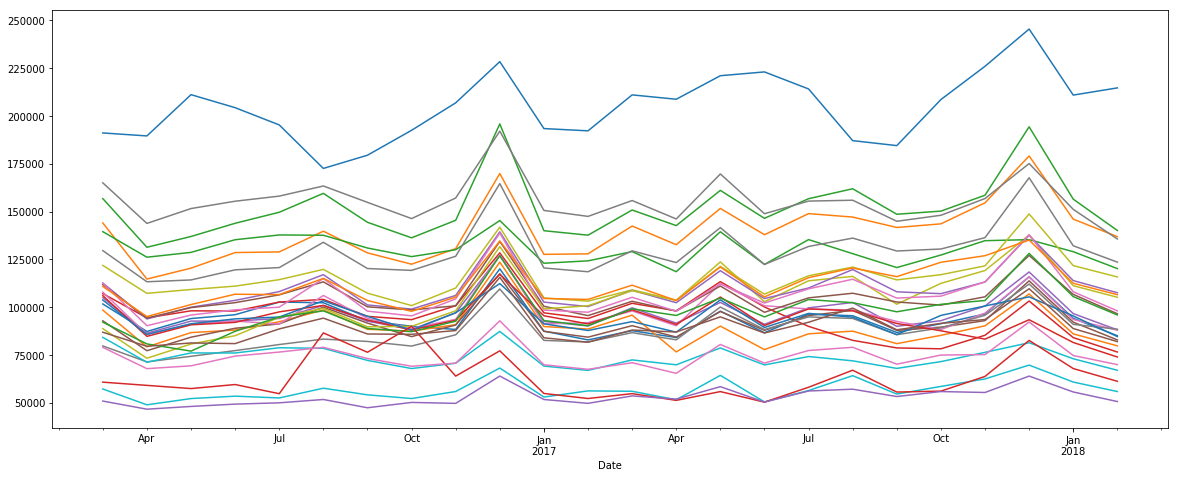

9


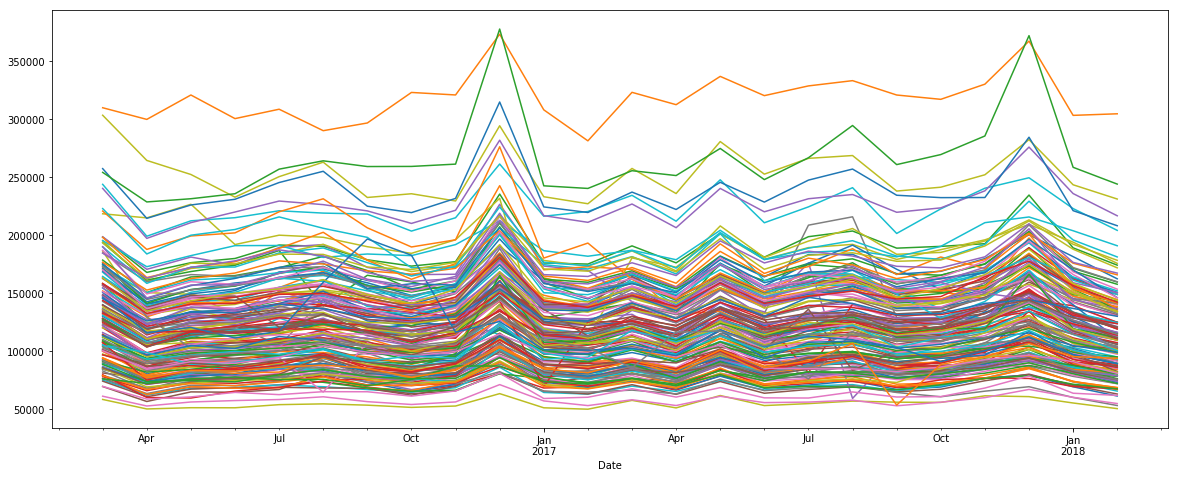

10


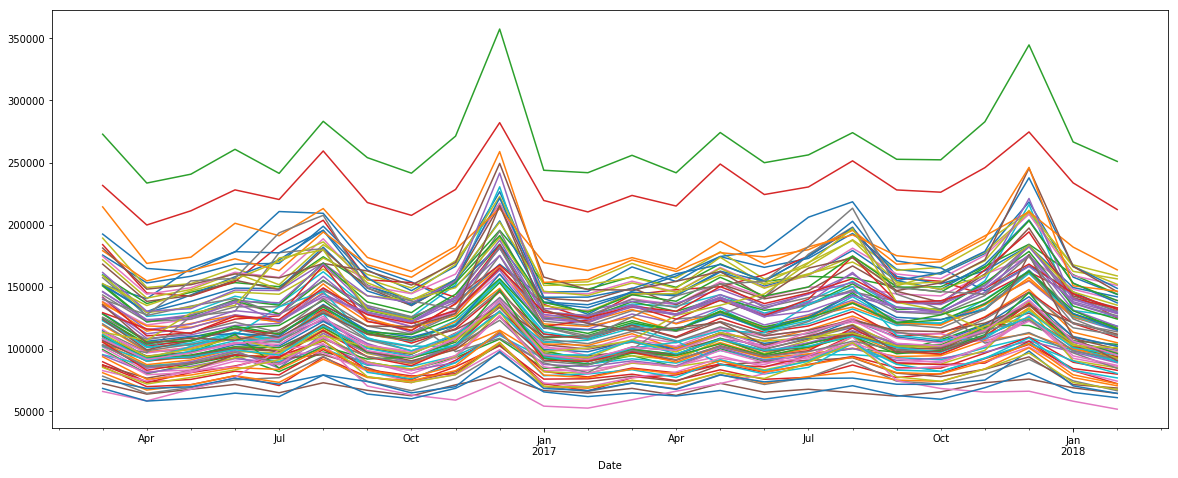

In [124]:
train_byRegion = train.groupby('Region')

plt.figure(figsize=(200,100))
for region,regStores in train_byRegion:
    print(region)
    
    ax = plt.subplot2grid((11,1),(int(region), 0))
    
    for key, store in regStores.groupby('StoreID'):
        store = store.set_index("Date")
        store.NumberOfSales.resample('M').sum().plot(ax = ax, figsize=(20,100),legend=False)
        #store.groupby(pd.Grouper(freq='M')).plot(ax = ax, x="Date", y="NumberOfSales",figsize=(20,100),legend=False)
        #sns.tsplot(data=store, time='Date', value='NumberOfSales')
        
    plt.show()
    

In [125]:
dic = {'IsHoliday':'mean',
       'IsOpen':'mean',
       'HasPromotions':'mean',
       'NearestCompetitor':'mean',
       'NumberOfCustomers':'sum',
       'NumberOfSales':'sum',
       'Region_AreaKM2':'mean',
       'Region_GDP':'mean',
       'Region_PopulationK':'mean',
       'Max_Gust_SpeedKm_h':'mean',
       'Max_Humidity':'mean',
       'Max_Sea_Level_PressurehPa':'mean',
       'Max_TemperatureC':'mean',
       'Max_VisibilityKm':'mean',
       'Max_Wind_SpeedKm_h':'mean',
       'Mean_Dew_PointC':'mean',
       'Mean_Humidity':'mean',
       'Mean_Sea_Level_PressurehPa':'mean',
       'Mean_TemperatureC':'mean',
       'Mean_VisibilityKm':'mean',
       'Mean_Wind_SpeedKm_h':'mean',
       'Min_Dew_PointC':'mean',
       'Min_Humidity':'mean',
       'Min_Sea_Level_PressurehPa':'mean',
       'Min_TemperatureC':'mean',
       'Min_VisibilitykM':'mean',
       'Precipitationmm':'mean',
       'WindDirDegrees':'mean'}

monthly_sales=train.groupby(["Region","StoreID",pd.Grouper(key = 'Date',freq='M')]).agg(dic)

In [131]:
monthly_sales.head(5)

IsHoliday    IsOpen  HasPromotions  \
Region StoreID Date                                             
0      1001    2016-03-31   0.000000  0.866667       0.466667   
               2016-04-30   0.066667  0.333333       0.366667   
               2016-05-31   0.096774  0.741935       0.387097   
               2016-06-30   0.033333  0.866667       0.433333   
               2016-07-31   0.000000  0.838710       0.322581   

                           NearestCompetitor  NumberOfCustomers  \
Region StoreID Date                                               
0      1001    2016-03-31              16755               3313   
               2016-04-30              16755               2215   
               2016-05-31              16755               4357   
               2016-06-30              16755               4375   
               2016-07-31              16755               4582   

                           NumberOfSales  Region_AreaKM2  Region_GDP  \
Region StoreID Date                                                    
0      1001    2016-03-31        39645.0            8410       10494   
               2016-04-30        37490.0            8410       10494   
               2016-05-31        65024.0            8410       10494   
               2016-06-30        64924.0            8410       10494   
               2016-07-31        67927.0            8410       10494   

                           Region_PopulationK  Max_Gust_SpeedKm_h  \
Region StoreID Date                                                 
0      1001    2016-03-31                1892           52.200001   
               2016-04-30                1892           44.000000   
               2016-05-31                1892           44.125000   
               2016-06-30                1892           42.222221   
               2016-07-31                1892           26.000000   

                           Max_Humidity  Max_Sea_Level_PressurehPa  \
Region StoreID Date                                                  
0      1001    2016-03-31     91.866667                1016.333333   
               2016-04-30     88.066667                1018.233333   
               2016-05-31     92.870968                1014.709677   
               2016-06-30     94.700000                1017.233333   
               2016-07-31     89.258065                1021.322581   

                           Max_TemperatureC  Max_VisibilityKm  \
Region StoreID Date                                             
0      1001    2016-03-31          1.733333         21.133333   
               2016-04-30         11.466667         26.000000   
               2016-05-31         16.322581         25.266666   
               2016-06-30         20.400000         25.500000   
               2016-07-31         24.774194         28.321428   

                           Max_Wind_SpeedKm_h  Mean_Dew_PointC  Mean_Humidity  \
Region StoreID Date                                                             
0      1001    2016-03-31           24.533333        -4.633333      76.266667   
               2016-04-30           21.966667         2.233333      67.800000   
               2016-05-31           22.290323         8.064516      74.096774   
               2016-06-30           21.100000        12.066667      76.533333   
               2016-07-31           17.645161        12.161290      62.516129   

                           Mean_Sea_Level_PressurehPa  Mean_TemperatureC  \
Region StoreID Date                                                        
0      1001    2016-03-31                 1012.066667          -1.066667   
               2016-04-30                 1014.300000           7.833333   
               2016-05-31                 1011.580645          12.516129   
               2016-06-30                 1014.466667          16.033333   
               2016-07-31                 1019.516129          19.258065   

                           Mean_VisibilityKm  Mean_Wind_SpeedKm_

In [273]:
for reg,regdf in monthly_sales.groupby(level=0):
    #

Region  StoreID  Date      
0       1001     2016-03-31    0.866667
                 2016-04-30    0.333333
                 2016-05-31    0.741935
                 2016-06-30    0.866667
                 2016-07-31    0.838710
                 2016-08-31    0.870968
                 2016-09-30    0.866667
                 2016-10-31    0.806452
                 2016-11-30    0.800000
                 2016-12-31    0.806452
                 2017-01-31    0.806452
                 2017-02-28    0.857143
                 2017-03-31    0.870968
                 2017-04-30    0.766667
                 2017-05-31    0.838710
                 2017-06-30    0.800000
                 2017-07-31    0.161290
                 2017-08-31    0.000000
                 2017-09-30    0.000000
                 2017-10-31    0.677419
                 2017-11-30    0.800000
                 2017-12-31    0.774194
                 2018-01-31    0.838710
                 2018-02-28    0.857143
        1009